<a href="https://colab.research.google.com/github/NHS-ML-AI/CONTAINER_OR_NOT/blob/main/CROP_IMG_GRID_FRAMES_Predicting_depth_in_an_image_with_Depth_Anything_CONTAINER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Anything

[Monocular depth estimation](https://huggingface.co/docs/transformers/v4.28.0/tasks/monocular_depth_estimation) is the task of estimating the depth value (distance relative to the camera) of each pixel given a single (monocular) RGB image.

Depth Anything is a new exciting model by the University of Hong Kong/TikTok that takes an existing neural network architecture for monocular depth estimation (namely the [DPT](https://huggingface.co/docs/transformers/model_doc/dpt) model with a [DINOv2](https://huggingface.co/docs/transformers/model_doc/dinov2) backbone), and scales up the dataset to train it on.

The authors design a "data engine" to collect and automatically annotate large-scale unlabeled data (~62 million images), which significantly enlarges the data coverage and thus is able to reduce the generalization error.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/depth_anything_overview.jpg"
alt="drawing" width="600"/>

<small> Depth Anything overview. Taken from the <a href="https://arxiv.org/abs/2401.10891">original paper</a>.</small>

The authors released various checkpoints which are now available on the Hugging Face [hub](https://huggingface.co/models?other=depth_anything).

Useful resources:

* Original paper: https://arxiv.org/abs/2401.10891.
* Docs: https://huggingface.co/docs/transformers/main/en/model_doc/depth_anything.

## Set-up environment

Let's start by installing our favorite library: 🤗 Transformers. We install from source here since the model is brand new at the time of writing.

In [1]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-j4nu_164
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-j4nu_164
  Resolved https://github.com/huggingface/transformers.git to commit 21fac7abba2a37fae86106f87fcf9974fd1e3830
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9677029 sha256=cc98c97c5cf958854d9473210bf703744a9c13c73be1ee3ec9001178f75e3174
  Stored in directory: /tmp/pip-ephem-wheel-cache-d74mhh05/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [2]:
#Librerias

import cv2
import torch
import requests
import numpy as np
from PIL import Image
from transformers import pipeline
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

In [3]:
#Funcion depth_estimation
def depth_estimation_IMG_640x480(image):
    """
    Estimación de profundidad en una imagen.

    :param imagen: Imagen de entrada de 640x480 px.
    :return: Imagen de profundidad estimada.
    """

    #Process
    pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")
    result = pipe(image)
    #result["depth"]

    #Model
    processor = AutoImageProcessor.from_pretrained("nielsr/depth-anything-small")
    model = AutoModelForDepthEstimation.from_pretrained("nielsr/depth-anything-small")

    """

    Let's prepare the image for the model using the image processor."""

    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    #print(pixel_values.shape)


    with torch.no_grad():
        outputs = model(pixel_values)
        predicted_depth = outputs.predicted_depth

    h, w = image.size[::-1]

    depth = torch.nn.functional.interpolate(predicted_depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]

    raw_depth = Image.fromarray(depth.cpu().numpy().astype('uint16'))
    raw_depth.save("predicted_depth.png")

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.cpu().numpy().astype(np.uint8)
    colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    #Output
    image_out=Image.fromarray(colored_depth)

    return image_out

In [4]:
## Función auxialiar

def create_image_grid(image_list, grid_size, output_path):
    """
    Crea una cuadrícula de imágenes y guarda el resultado en un archivo.

    :param image_list: Lista de objetos de imagen PIL.
    :param grid_size: Tupla (filas, columnas) que define el tamaño de la cuadrícula.
    :param output_path: Ruta del archivo de salida donde se guardará la imagen de la cuadrícula.
    """
    # Verifica que el número de imágenes coincida con el tamaño de la cuadrícula
    if len(image_list) != grid_size[0] * grid_size[1]:
        raise ValueError("El número de imágenes no coincide con el tamaño de la cuadrícula.")

    # Obtener el tamaño de las imágenes
    img_width, img_height = image_list[0].size

    # Crear una nueva imagen para la cuadrícula
    grid_width = img_width * grid_size[1]
    grid_height = img_height * grid_size[0]
    grid_image = Image.new('RGB', (grid_width, grid_height))

    # Colocar las imágenes en la cuadrícula
    for index, img in enumerate(image_list):
        row = index // grid_size[1]
        col = index % grid_size[1]
        x = col * img_width
        y = row * img_height
        grid_image.paste(img, (x, y))

    # Guardar la imagen de la cuadrícula
    grid_image.save(output_path)

    return grid_image

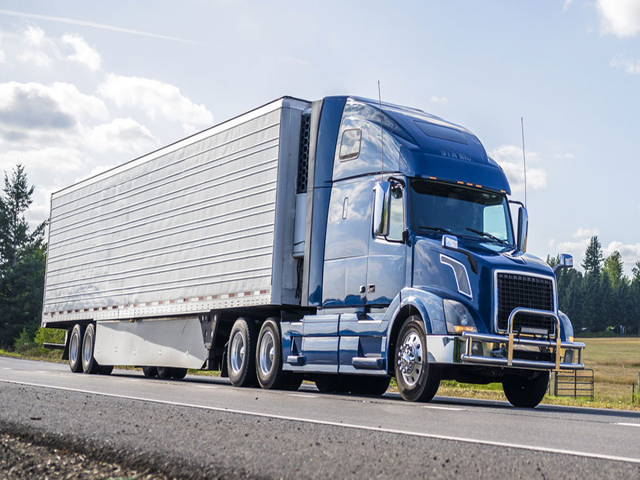

In [5]:
##Image
url = 'https://www.geotab.com/CMS-Media-production/Blog/NA/_2020/february/road-trucking/Thumb-Solving-over-the-road-trucking-challenges-with-analytics.jpg'

image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((640, 480))
image.size
image

In [6]:
img_out=depth_estimation_IMG_640x480(image)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

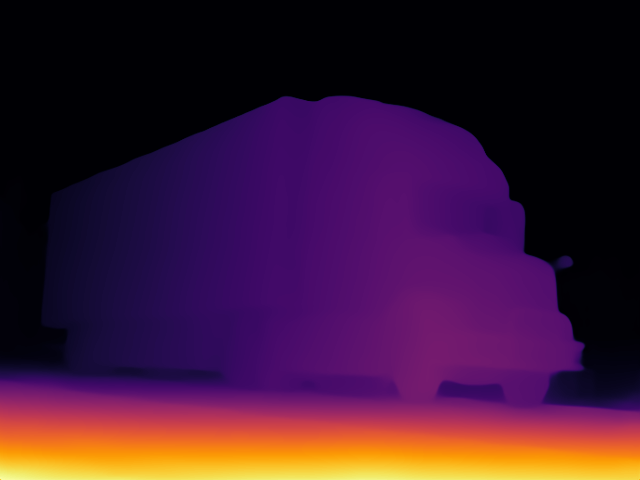

In [7]:
img_out

In [21]:
ls_img_out=[]

num_frames = 6

porciento= 50

fact= 100/porciento

lim = int(300/num_frames)

for i in range(lim,350,lim):
    if i <100:
        name_img = "frame_00" + str(i) + ".jpg"
    else:
        name_img = "frame_0" + str(i) + ".jpg"
    image = Image.open(name_img)
    w,h = image.size
    box = (int(w/fact),0, w, h)

    # ROI por %
    region = image.crop(box)
    region = region.resize((640, 480))
    img_out=depth_estimation_IMG_640x480(region)
    ls_img_out.append(img_out)
    print("Process",i/lim )

Process 1.0
Process 2.0
Process 3.0
Process 4.0
Process 5.0
Process 6.0


In [22]:
# Grid image
grid_size = (2, 3)  # num filas y num columnas

# Ruta del archivo de salida
output_path = 'cuadricula.jpg'

grid_image = create_image_grid( ls_img_out, grid_size, output_path)

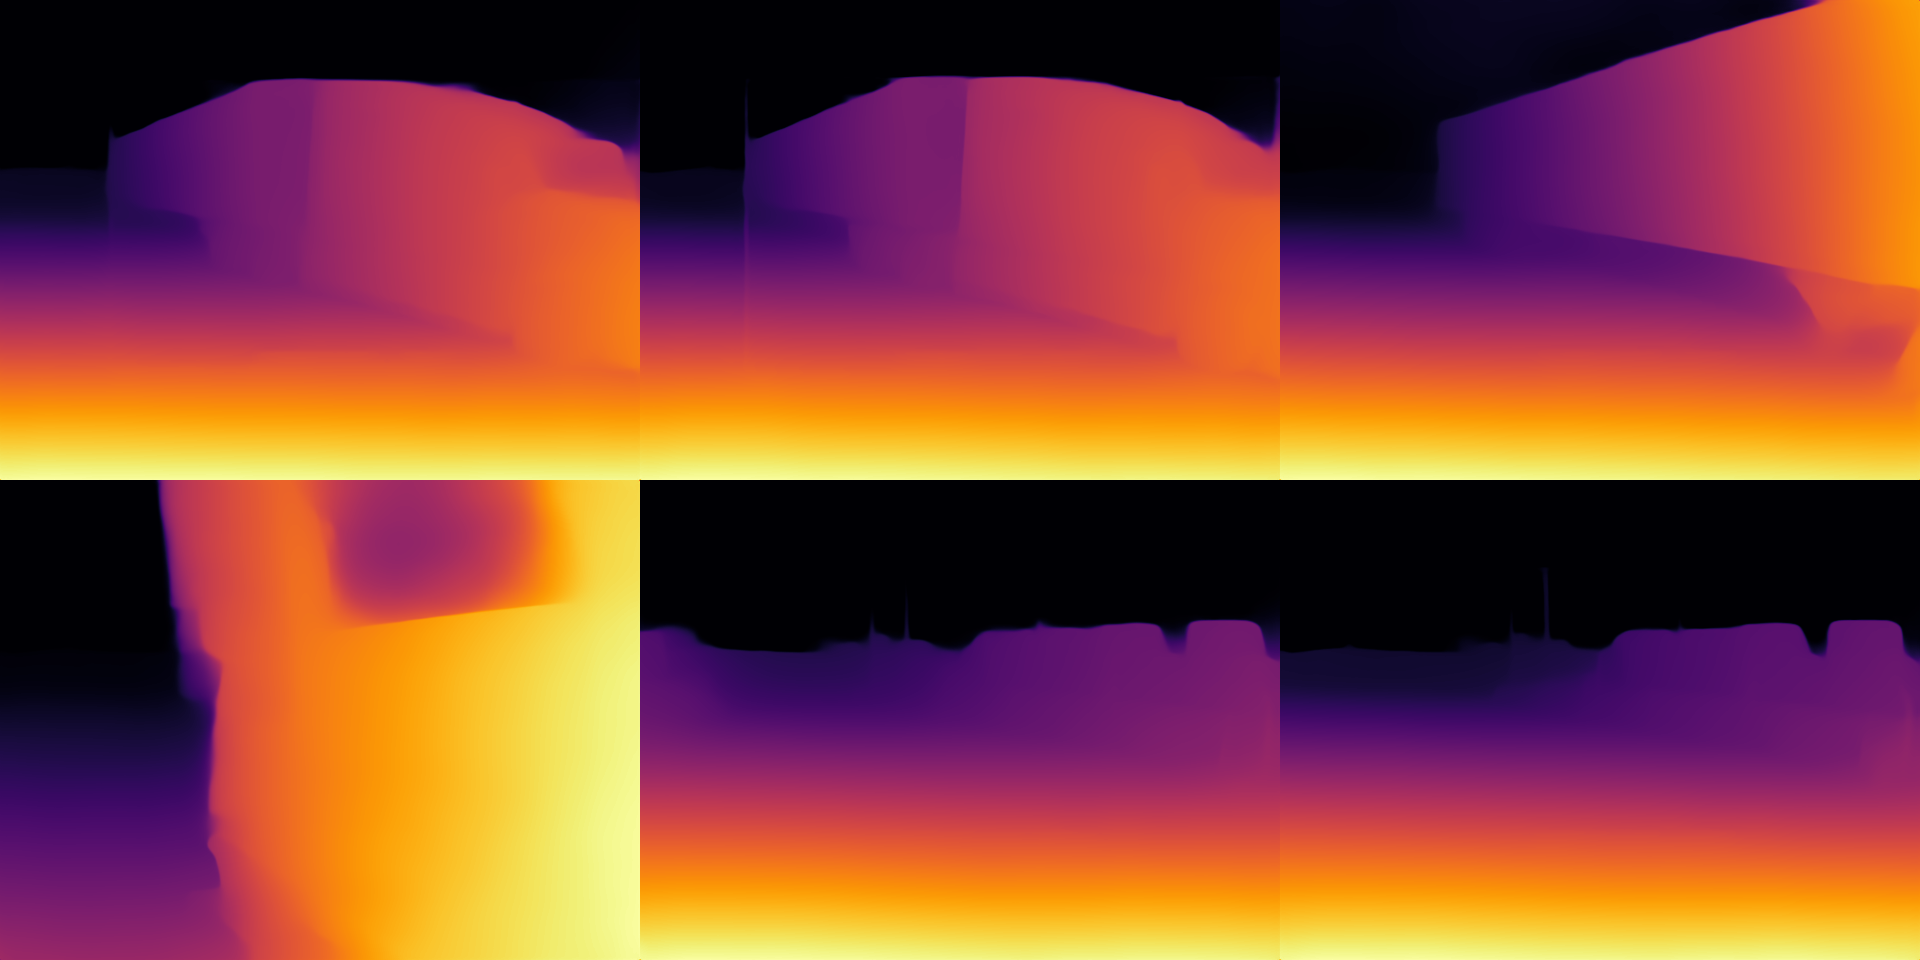

In [23]:
grid_image